In [15]:
%load_ext autoreload
%autoreload 2
import eval_models
import pandas as pd
import numpy as np
from boruta import BorutaPy
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['font.size'] = 25

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
X_art_train,X_art_test,y_art_train,y_art_test=eval_models.get_train_test("artificial")

## No standarization at all

In [3]:
RF = RandomForestClassifier(n_jobs=-1, max_depth=6)
feat_select = BorutaPy(RF, n_estimators='auto', verbose=0)
feat_select.fit(X_art_train.values,y_art_train)
X_art_train_boruta=X_art_train.iloc[:,feat_select.support_]
X_art_test_boruta=X_art_test.iloc[:,feat_select.support_]

In [4]:
noscaling_res=eval_models.get_models_ba(X_art_train_boruta,
                              X_art_test_boruta,
                              y_art_train,
                              y_art_test
                             )

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression 0.64
RandomForestClassifier 0.892
AdaBoostClassifier 0.634
LGBMClassifier 0.894
XGBClassifier 0.872
20  features in the dataset


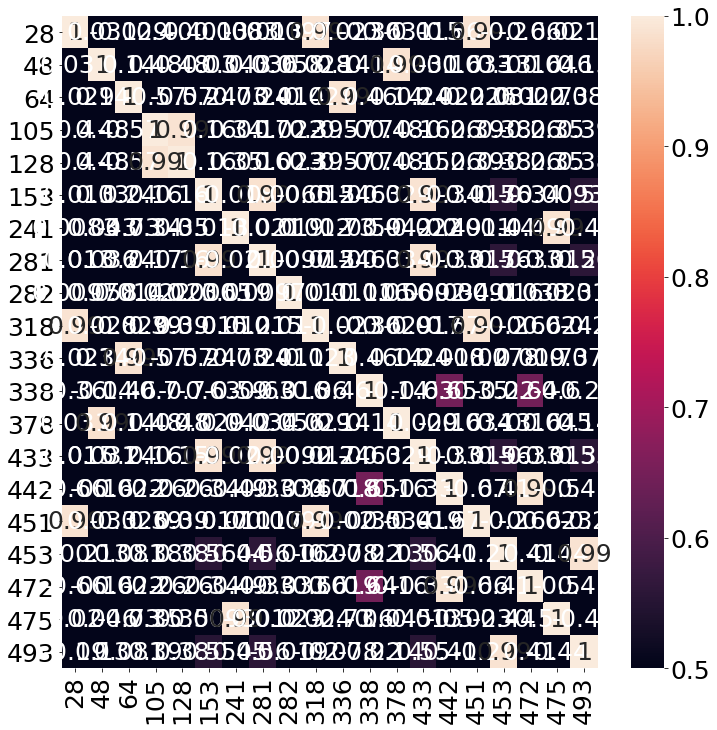

In [5]:
plt.figure(figsize=(12,12))
corr = X_art_train_boruta.corr()
sns.heatmap(corr,annot=True,vmin=0.5,vmax=1)
plt.show()

In [6]:
X_train_no_corr=eval_models.delete_corr(X_art_train_boruta)

In [7]:
noscaling_res_cor=eval_models.get_models_ba(X_train_no_corr,
                              X_art_test_boruta,
                              y_art_train,
                              y_art_test
                             )

LogisticRegression 0.626
RandomForestClassifier 0.892
AdaBoostClassifier 0.62
LGBMClassifier 0.882
XGBClassifier 0.888
10  features in the dataset


## Standarization after Boruta (not really expecting it to work)

In [8]:
X_art_train_boruta_sc,X_art_test_boruta_sc=eval_models.standarize(X_art_train_boruta,X_art_test_boruta)

In [9]:
X_train_no_corr2=eval_models.delete_corr(X_art_train_boruta_sc)

In [10]:
noscaling_res_cor=eval_models.get_models_ba(X_train_no_corr2,
                              X_art_test_boruta_sc,
                              y_art_train,
                              y_art_test
                             )

LogisticRegression 0.632
RandomForestClassifier 0.892
AdaBoostClassifier 0.62
LGBMClassifier 0.872
XGBClassifier 0.888
10  features in the dataset


## Standarization before Boruta

In [11]:
X_art_train_sc,X_art_test_sc=eval_models.standarize(X_art_train,X_art_test)

In [12]:
### (suggested max_depth between 3 and 7) podobno
RF = RandomForestClassifier(n_jobs=-1, max_depth=7)
feat_select = BorutaPy(RF, n_estimators='auto', verbose=0)
feat_select.fit(X_art_train_sc.values,y_art_train)
X_art_train_sc_boruta=X_art_train_sc.iloc[:,feat_select.support_]
X_art_test_sc_boruta=X_art_test_sc.iloc[:,feat_select.support_]

In [13]:
scaled_res=eval_models.get_models_ba(X_art_train_sc_boruta,
                              X_art_test_sc_boruta,
                              y_art_train,
                              y_art_test
                             )

LogisticRegression 0.614
RandomForestClassifier 0.898
AdaBoostClassifier 0.624
LGBMClassifier 0.884
XGBClassifier 0.88
22  features in the dataset


In [14]:
plt.figure(figsize=(12,12))
corr = X_art_train_sc_boruta.corr()
sns.heatmap(corr,annot=True,vmin=0.5,vmax=1)
plt.show()

KeyboardInterrupt: 

In [ ]:
X_art_train_sc_no_corr=eval_models.delete_corr(X_art_train_sc_boruta)

In [ ]:
scaled_res_cor=eval_models.get_models_ba(X_art_train_sc_no_corr,
                              X_art_test_sc_boruta,
                              y_art_train,
                              y_art_test
                             )

## Cross validation (with standarization before Boruta)

In [ ]:
kf = KFold(n_splits=5,shuffle=True)
models_res=[]
for train_idx, val_idx in tqdm(kf.split(X_art_train)):
    X_train=X_art_train.iloc[train_idx,:]
    X_val=X_art_train.iloc[val_idx,:]
    y_train=y_art_train[train_idx]
    y_val=y_art_train[val_idx]
    
    X_train_sc,X_val_sc=eval_models.standarize(X_train,X_val)
    
    RF = RandomForestClassifier(n_jobs=-1, max_depth=6)
    feat_select = BorutaPy(RF, n_estimators='auto', verbose=0)
    feat_select.fit(X_train.values,y_train)
    
    X_train_sc_boruta=X_train_sc.iloc[:,feat_select.support_]
    X_val_sc_boruta=X_val_sc.iloc[:,feat_select.support_]
    

    with open('../data/boruta/artificial-features.csv', 'a') as f:
        np.savetxt(f, np.where(feat_select.support_), delimiter=",", fmt='%i')
    f.close()
    X_train_sc_boruta_no_corr=eval_models.delete_corr(X_train_sc_boruta)
    tmp=eval_models.get_models_ba(X_train_sc_boruta_no_corr,X_val_sc_boruta,y_train,y_val)
    models_res.append(tmp)

In conclusion we could expect sth around 0.84 balanced accuracy score with 10 features.
We could use some other method to select only the 5 best ones. Nie wiem czy jest sens bo użycie 10 zamiast 5 to kara na poziomie 1 punktu procentowego

### Having run Boruta x times we will select only those variables which have been selected at least 95% of the time
remember to specify x_times!

In [17]:
x_times=5
boruta_all_results=pd.read_csv('../data/boruta/artificial-features.csv',header=None,sep="\n")
boruta_all_results=boruta_all_results.iloc[:,0].str.split(',', expand=True)

In [18]:
boruta_all_array=np.array(list(filter(None, np.array(boruta_all_results).flatten()))).astype(np.int64)
unique, counts=np.unique(np.array(boruta_all_array).flatten(),return_counts=True)
columns_boruta= unique[counts>=x_times*0.95]

In [19]:
X_art_train_boruta_multiple=X_art_train.iloc[:,columns_boruta]
X_art_train_boruta_multiple.head()

,28,48,64,105,128,153,241,281,318,336,338,378,433,442,451,453,472,475,493
508,468,537,588,484,478,517,425,487,443,602,573,548,509,613,469,625,533,377,636
242,493,434,468,554,484,681,534,563,530,451,343,434,625,377,488,526,415,529,546
1024,493,497,301,755,500,433,578,448,529,278,389,516,451,440,485,453,458,612,464
782,503,434,367,612,490,445,527,452,555,327,441,409,459,471,491,460,470,521,473
677,479,504,586,454,475,596,489,533,482,584,472,524,576,434,477,489,447,475,506


Results without standarization and removing based on VIF

In [20]:
eval_models.get_models_ba(X_art_train_boruta_multiple,
                              X_art_test,
                              y_art_train,
                              y_art_test,
                          n_estimators=250
                             )

LogisticRegression 0.642
RandomForestClassifier 0.88
AdaBoostClassifier 0.622
LGBMClassifier 0.878
XGBClassifier 0.876
19  features in the dataset


,Classifier,BA score
0,LogisticRegression,0.642
1,RandomForestClassifier,0.880
2,AdaBoostClassifier,0.622
3,LGBMClassifier,0.878
4,XGBClassifier,0.876


Now we standarize both sets and remove some variables based on VIF

In [21]:
X_art_train_scaled,X_art_test_scaled=eval_models.standarize(X_art_train,X_art_test)
X_art_train_scaled_boruta_multiple=X_art_train_scaled.iloc[:,columns_boruta]

In [22]:
res_boruta_no_vif=eval_models.get_models_ba(X_art_train_scaled_boruta_multiple,
                              X_art_test_scaled,
                              y_art_train,
                              y_art_test,
                          n_estimators=250
                             )
res_boruta_no_vif['VIF']="No"

LogisticRegression 0.638
RandomForestClassifier 0.886
AdaBoostClassifier 0.62
LGBMClassifier 0.878
XGBClassifier 0.876
19  features in the dataset


In [23]:
X_art_train_scaled_boruta_multiple_vif=eval_models.delete_multicollinear(X_art_train_scaled_boruta_multiple)

18
17
16
15
14
13
12
11
10
9
8
7
6
5
5 features left


In [24]:
res_boruta_yes_vif=eval_models.get_models_ba(X_art_train_scaled_boruta_multiple_vif,
                              X_art_test_scaled,
                              y_art_train,
                              y_art_test,
                          n_estimators=250)
res_boruta_yes_vif['VIF']="Yes"

LogisticRegression 0.642
RandomForestClassifier 0.886
AdaBoostClassifier 0.564
LGBMClassifier 0.848
XGBClassifier 0.852
5  features in the dataset


In [25]:
res_boruta_all=pd.concat([res_boruta_no_vif,res_boruta_yes_vif])
res_boruta_all

,Classifier,BA score,VIF
0,LogisticRegression,0.638,No
1,RandomForestClassifier,0.886,No
2,AdaBoostClassifier,0.620,No
3,LGBMClassifier,0.878,No
4,XGBClassifier,0.876,No
0,LogisticRegression,0.642,Yes
1,RandomForestClassifier,0.886,Yes
2,AdaBoostClassifier,0.564,Yes
3,LGBMClassifier,0.848,Yes
4,XGBClassifier,0.852,Yes


In [26]:
res_boruta_all.replace(to_replace=['LogisticRegression','RandomForestClassifier','AdaBoostClassifier','LGBMClassifier','XGBClassifier'],value=['Logistic Regression','Random Forest','AdaBoost','LightGBM','XGBoost'],inplace=True)

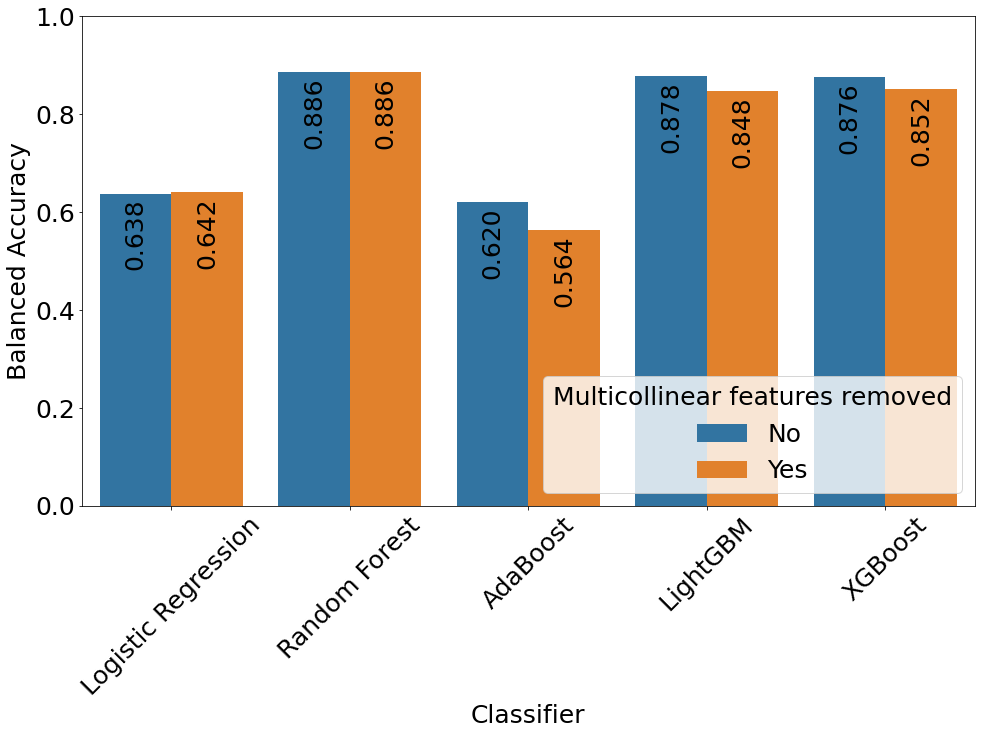

In [30]:
bars = sns.barplot(x='Classifier', y='BA score', hue='VIF', data=res_boruta_all)
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.3f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()-0.1), ha='center', va='center', xytext=(0, 8), rotation=90,
                   textcoords='offset points')
plt.ylim(0, 1)
plt.legend(loc=4, title='Multicollinear features removed')
plt.xlabel('Classifier')
plt.ylabel('Balanced Accuracy')
#plt.title('Artificial\nClassifiers performance after Boruta feature selection')
plt.xticks(rotation=45)
plt.show()